# <span style="color:#cc241d">Using TomoTwin for particle picking</span>

TomoTwin is an embedding-based cryo-ET particle picking procedure for cryo-ET [[1](https://tomotwin-cryoet.readthedocs.io/en/stable/index.html)] [[2](https://doi.org/10.1038/s41592-023-01878-z)]. TomoTwin was originally designed to identify proteins in a single tomogram de novo without manually creating training data. Since this workflow is not optimized for large-throughput data analysis of hundreds of tomograms, we modify it slightly to use some manually annotated tomograms as training for subsequent particle picking in unseen tomograms. This is essentially a two step procedure:

1. From the particle picks in the annotated tomograms, identify a few `reference` particles for each particle type of interest, such as for ribosomes, apo-ferritins, etc.
2. Use the embeddings of the `reference` particles for similarity-based annotation in unseen tomograms.

In this notebook, we provide an example of a workflow to pick ribosomes from unseen tomograms.
We divide this notebook into the following sections:

- [Section 0](#install): Install and setup.
- [Section 1](#section1): Data preprocessing and embedding calculation.
- [Section 2](#section2): Similarity-based particle picking.
- [Section 3](#section3): Refining and analyzing the picks.
- [Section 4](#observations): Observations

The inputs and outputs are as follows:  
**Inputs**:

- Tomograms (>1) stored using the copick data model. Thhe copick data model is described in the Copick documentation [[3]](https://uermel.github.io/copick/).
- Ribosome annotations for one of the tomograms, stored in copick format. We refer to the remaining tomograms as `unseen` tomograms.
- TomoTwin Pytorch model.
- Optionally, ribosome annotations for the unseen tomograms.

**Outputs**:

- Proposed ribosome annotations for the remaining tomograms.
- Optionally, if the annotations for the unseen tomgorams are provided, then we also calculate the evaluation metrics for the unseen tomograms.

\[1\] [Tomotwin's User Guide](https://tomotwin-cryoet.readthedocs.io/en/stable/index.html)  
\[2\] [Tomotwin paper](https://doi.org/10.1038/s41592-023-01878-z)  
\[3\] [Copick documentation](https://uermel.github.io/copick/)


---


<a id='install'></a>

## <span style="color:#d65d0e">Install and setup</span>


### <span style="color:#d79921">Installation</span>


There are two ways to install the packages required for this notebook: directly installing all the packages using a conda environment file, or a custom step-by-step installation.


#### <span style="color:#689d6a"> Option 1: direct install </span>

Download the provided `tomotwin_copick_environment.yml` file and run

```bash
mamba env create -f tomotwin_copick_environment.yml
mamba activate tomotwin_copick
```

This might not work if Cuda version is different from 12.0, or for some version issues. If this does not work, try the custom install option.


---


#### <span style="color:#689d6a">Option 2: custom install</span>

- Go to the [RapidsAI install page](https://docs.rapids.ai/install). Select the appropriate CUDA version along with the options `Conda`, `Python 3.11`, `Standard`, `JupyterLab`, and `PyTorch`. Copy and modify the command thus generated. The modified command might look like:

```bash
mamba create -n tomotwin2 -c rapidsai -c conda-forge -c nvidia  \
    rapids=24.06 python=3.11 cuda-version=12.0 \
    jupyterlab pytorch
```

- Activate the new environment:

```bash
mamba activate tomotwin2
```

- Install other conda packages:

```bash
mamba install numpy scikit-learn scikit-image pytorch-metric-learning \
    numba tabulate tqdm ipywidgets zarr ome-zarr fsspec trimesh matplotlib \
    mrcfile pydantic starfile pytorch::torchtriton
```

There could be some redundancies in packages listed here.

- Install necessary pypi packages:

```bash
pip install tomotwin-cryoet --no-deps
pip install copick --no-deps
```

The "--no-deps" part is to remove any conflict between the stated dependencies in tomotwin-cryoet and copick libraries with the previously installed packages.

We have verified that this workflow works for Python 3.11 and CUDA 12.0, but this might need modification for other setups. Note that when copick is installed this way, it can only be used for the data access, not for the ChimeraX visualization.


---


### <span style="color:#d79921">Downloading the TomoTwin embedding model</span>

The TomoTwin embeddings are calculated using a pre-trained Pytorch model provided by the TomoTwin developers. The latest model is available to download from https://zenodo.org/records/8358240. The path to the model is used in the subsequent processing.


---


### <span style="color:#d79921">Imports and configurations</span>

Setting up the imports and parameters used broadly in the subsequent sections. These parameters are based on a few assumptions about the copick data structure.

**Assumptions**

1. The copick directory structure is described in the file `filesystem_overlay_only.json`
2. It contains tomograms with voxel size 10 A.
3. It contains weighted-back-projected tomograms under the `denoised` tomogram type. Optionally,the notebook also uses the `denoised` tomo type to visualize some reference and picked particles.

Note that we choose the tomograms generated from weighted backprojection since some limited exploratory tests showed that TomoTwin performed well with these among our available reconstructions. We recommend analysis of more data and multiple reconstruction approaches for practical applications of this, or any such similar, workflow.


In [4]:
import os

cur_dir = (
    "/home/saugat.kandel/projects_sk/code/2024_czii_mlchallenge_notebooks/tomotwin_picking_notebook"
)

os.chdir(cur_dir)

In [33]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copick.impl.filesystem import CopickRootFSSpec

import copick_tools
import tomotwin_notebook_helper as helper
from copy import deepcopy

In [41]:
# Parameter setup for the notebook

# This is the list of tomograms used in the notebook.
# TS_99_9 is used as the reference, and the other two are used as test tomograms.
#
tomo_list = ["TS_99_9", "TS_73_6", "TS_5_4"]
data_type = "denoised"
voxel_size = 10.0

copick_root_path = Path(
    "/hpc/projects/group.czii/mlchallenge_202406_curation/ml_curated_pickathon_June2024/"
)
overlay_fname = "filesystem_overlay_only.json"
copick_root = CopickRootFSSpec.from_file(copick_root_path / overlay_fname)

# Setting up the directory for the TomoTwin embeddings
tomotwin_root = Path("embeddings")
tomotwin_root.mkdir(exist_ok=True)

# Choosing the tomogram to use as "training" reference.
ref_tomo = "TS_99_9"
test_tomos = ["TS_73_6", "TS_5_4"]

protein = "ribosome"
protein_diameters = {"ribosome": 320 / voxel_size}

out_dir_base = Path(cur_dir)

---


<a id='section1'></a>

## <span style="color:#d65d0e">Data preprocessing and embedding calculation</span>


### <span style="color:#d79921">Converting tomograms from `OME-ZARR` format to `.mrc` files:</span>

The provied tomograms are stored in OME-ZARR format with the copick directory structure. Since Tomotwin only reads tomograms in MRC format, we have to convert these tomograms.

**Input**:

- Copick denoised tomograms.

**Output**:

- Individual mrc files in directory `mrc_phantom/denoised` as `{tomo_name}_denoised.mrc`.


In [ ]:
# Conversion script. This should take only a few seconds.

out_dir = out_dir_base / f"mrc_phantom/{data_type}"
out_dir.mkdir(exist_ok=True, parents=True)

mrc_paths = {}
for tomo in tomo_list:
    print("Converting ", tomo)
    tomo_array = (
        copick_root.get_run(tomo).get_voxel_spacing(voxel_size).get_tomogram(data_type).numpy()
    )

    out_mrc_fname = out_dir / f"{tomo}_{data_type}.mrc"
    helper.save_mrc(tomo_array, out_mrc_fname, voxel_size=voxel_size)
    mrc_paths[tomo] = out_mrc_fname

---


### <span style="color:#d79921">Extracting the "subvolumes" around selected reference particles from the annotated tomogram.</span>

We use the tomogram TS_115_4 as the reference tomogram from which the reference particles are extracted. The tomogram contains 82 ribosome --- using each of these particles as references for subsequent processing would require a lot of computation, but our exploratory results showed that the overall particle picking did not improve when we used more than about 10-15 particles. We can reduce the particle count using many approaches, of which we discuss two:

1. Random selection of a predefined number particles. We follow the random selection approach in this notebook.
2. Using a dimensionality reduction and clustering based approach using the `napari-tomotwin` plugin for the Napari GUI. The [tomotwin tutorial](https://tomotwin-cryoet.readthedocs.io/en/stable/tutorials/tutorials_overview.html#tutorial-2-clustering-based-particle-picking) discusses this approach. We were unable to get the `napari-tomotwin` plugin during the time of writing this notebook --- the plugin authors are looking into this.

**Input**:

- Locations of the centers of the ribosomes for the reference tomogram. This should be in copick format.

**Outputs**:

- Individual mrc files containing the `37 X 37 X 37 voxels` subvolume around 10 randomly selected reference particles. They are stored in the directory `embeddings/denoised/references/ribosome/`.


#### <span style="color:#689d6a"> Selecting reference particles </span>


In [42]:
# Getting the ribosome coordinates from the copick filesystem
reference_ribo_coords_xyz = copick_tools.custom_get_copick_protein_coords(
    copick_root=copick_root, tomo_id=ref_tomo, protein_name="ribosome"
)

In [43]:
# Random selection of the reference particles
rng = np.random.default_rng(10)
reference_ribo_coords_xyz = rng.choice(reference_ribo_coords_xyz, 10, replace=False)

---


#### <span style="color:#689d6a">Visualizing the denoised z-projection (of width 300A = 30 voxels) of the reference particles </span>

It is hard to see the particles in the denoised tomogram, so we use the denoised tomogram for the visualization.


In [44]:
# First retrieve the corresponding denoised mrc file

tomo_array = (
    copick_root.get_run(ref_tomo).get_voxel_spacing(voxel_size).get_tomogram(data_type).numpy()
)
tomo_array_xyz = tomo_array.transpose(2, 1, 0)

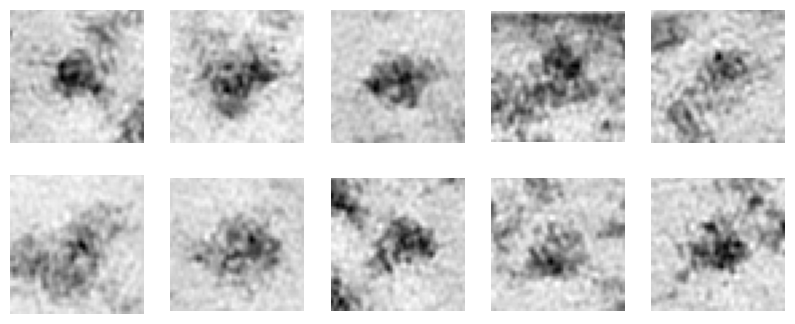

In [45]:
# Extract the reference projections and plot them

reference_projections = [
    helper.get_particle_slab_projection(tomo_array_xyz=tomo_array_xyz, particle_coord_xyz=coords)
    for coords in reference_ribo_coords_xyz
]

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axs.flat):
    ax.imshow(reference_projections[i], cmap="gray")
    ax.axis("off")
plt.show()

---


### <span style="color:#689d6a">Extracting the particle subvolumes from the denoised tomograms</span>

1. First save the coordinates as a `.coords` file.
2. Extract a 37 x 37 x 37 voxel subvolume centered at each particle using TomoTwin. The subvolume size is a TomoTwin default. This step is related to [Step 2](https://tomotwin-cryoet.readthedocs.io/en/stable/tutorials/tutorials_overview.html#tutorial-1-reference-based-particle-picking) in the TomoTwin tutorial.
3. Store the subvolumes in the directory structure  
   `embeddings/denoised/references/ribosome/`


In [46]:
# Storing the reference ribosome coordinates
ref_ribo_coords_out_dir = tomotwin_root / data_type / "references/ribosome"
ref_ribo_coords_out_dir.mkdir(exist_ok=True, parents=True)

ref_ribo_coords_out_fname = ref_ribo_coords_out_dir / f"{ref_tomo}.coords"

np.savetxt(ref_ribo_coords_out_fname, reference_ribo_coords_xyz, delimiter=" ")

In [ ]:
# Extracting the subvolumes for the particles. This should take a minute or less.
# If tomotwin exits with a error about how the file already exists, then try removing any .mrc files {ref_ribo_coords_out} directory.
# If there is a "command not found" error, then try running the command in the terminal in the current directory and with the tomotwin_copick conda environment.
subvolume_out_path = tomotwin_root / data_type / "subvolumes"
helper.run_tomotwin_subolume_extraction(
    coords_fname=ref_ribo_coords_out_fname,
    mrc_fname=mrc_paths[ref_tomo],
    out_dir_path=ref_ribo_coords_out_dir,
    protein_name="ribosome",
)

---


#### <span style="color:#d79921">Calculating the embeddings for the test tomogram volumes and the reference particle subvolumes:</span>

We generate the embeddings using the TomoTwin command line interface, following [Steps 3 and 4](https://tomotwin-cryoet.readthedocs.io/en/stable/tutorials/tutorials_overview.html#embed-your-tomogram) in the TomoTwin Tutorial 1. The important parameter here is the "stride". For the tomograms, we follow the tomotwin tutorial and use a strid of 2, thereby calculating the embedding for every other voxel in the tomogram volume.

It takes about an hour to calculate the embeddings for a single tomogram in a single A40 GPU. The embeddings for different tomograms can be calculated in parallel with multiple GPUs or cluster nodes by running the command in the terminal, as shown in the [Tomotwin tutorial](https://tomotwin-cryoet.readthedocs.io/en/stable/tutorials/tutorials_overview.html). The tutorial also contains some strategies to accelerate the embedding calculation.

**Input**:

- The path to the tomotwin embedding model.
- Tomogram mrc files stored in `mrc_phantom/denoised/{tomo_name}_denoised.mrc`
- Reference particle subvolume mrcs stored as ``embeddings/denoised/references/ribosome/*.mrc`.

**Outputs**:

- Tomogram embeddings are stored as `embeddings/denoised/tembs/{tomo_name}_denoised.temb`.
- Embeddings for the all the reference ribosomes are concatenated and stored in `embeddings/denoised/references/ribosome/embeddings.temb`.

The embeddings files are pandas dataframes stored in pickle format.


In [39]:
model_path = "/hpc/projects/group.czii/saugat.kandel/tomotwin_album/tomotwin_latest.pth"

In [40]:
test_mrc_paths = deepcopy(mrc_paths)
test_mrc_paths.pop(ref_tomo)

PosixPath('/home/saugat.kandel/projects_sk/code/2024_czii_mlchallenge_notebooks/tomotwin_picking_notebook/mrc_phantom/denoised/TS_99_9_denoised.mrc')

In [ ]:
# Calculating the embeddings for the tomograms
for tomo, mrc_path in test_mrc_paths.items():
    out_dir_path = tomotwin_root / data_type / "tembs"
    helper.run_tomotwin_embedding_calculation(
        input_mrc_path=mrc_path, model_path=model_path, output_dir_path=out_dir_path
    )

In [ ]:
# Calculating the embeddings for the subvolumes
subvolume_mrc_paths = list(ref_ribo_coords_out_dir.glob("*.mrc"))
print(subvolume_mrc_paths)
helper.run_tomotwin_subvolume_embedding_calculation(
    model_path=model_path,
    subvolume_mrc_paths=subvolume_mrc_paths,
    out_dir_path=ref_ribo_coords_out_dir,
)

---


<a id='section2'></a>

## <span style="color:#d65d0e"> Similarity-based particle picking </span>

Similarity-based particle picking is a two step process:

1. similarity score calculation.
2. locating potential particle positions.

These steps follow Steps 5 and 6 in the [TomoTwin tutorial](https://tomotwin-cryoet.readthedocs.io/en/stable/tutorials/tutorials_overview.html).

**Inputs**:

- Individual tomogram embeddings stored as `embeddings/denoised/tembs/{tomo_name}_denoised.temb`.
- Refererence ribosome embeddings stored in `embeddings/denoised/references/ribosome/embeddings.temb`

**Outputs**:

- The similarity scores calculated for each tomogram are stored in `embeddings/denoised/maps/{tomo_name}/ribosome/map.tmap`.
- The potential particle picks for each tomogram are stored in `embeddings/denoised/maps/{tomo_name}/ribosome/located.tloc`.

The map and location files are both pandas dataframes stored in pickle format.


#### <span style="color:#d79921">Calculating the similarity score map</span>

We compare the reference particle embedding to the each embedding of the tomogram volume embedding to generate a per-particle similarity score map for the tomogram volume. This involves a pairwise similarity calculation between each pair of the reference embeddings and voxel-wise embeddings of the tomogram volume.


In [48]:
tomo_embedding_paths = {
    tomo: tomotwin_root / data_type / "tembs" / f"{tomo}_{data_type}_embeddings.temb"
    for tomo in test_tomos
}
assert all([path.exists() for path in tomo_embedding_paths.values()])

In [49]:
ref_embedding_path = tomotwin_root / data_type / "references/ribosome/embeddings.temb"
assert ref_embedding_path.exists()

In [50]:
base_map_out_dir = tomotwin_root / data_type / "maps"
base_map_out_dir.mkdir(exist_ok=True)

In [52]:
tomo_embedding_paths

{'TS_73_6': PosixPath('embeddings/denoised/tembs/TS_73_6_denoised_embeddings.temb'),
 'TS_5_4': PosixPath('embeddings/denoised/tembs/TS_5_4_denoised_embeddings.temb')}

In [56]:
# Running the similarity map calculations

ribo_map_out_dirs = {}
for tomo, emb_path in tomo_embedding_paths.items():
    print(f"Embedding for {tomo} is stored at {emb_path}")
    map_out_dir = base_map_out_dir / tomo
    map_out_dir.mkdir(exist_ok=True)

    ribo_map_out_dir = map_out_dir / "ribosome"
    ribo_map_out_dir.mkdir(exist_ok=True)

    print(f"Similarity map for {tomo} is stored in {map_out_dir}")
    helper.run_tomotwin_similarity_calculation(
        ref_embedding_fname=ref_embedding_path,
        tomo_embedding_fname=emb_path,
        out_dir_path=ribo_map_out_dir,
    )
    ribo_map_out_dirs[tomo] = ribo_map_out_dir

Embedding for TS_73_6 is stored at embeddings/denoised/tembs/TS_73_6_denoised_embeddings.temb
Similarity map for TS_73_6 is stored in embeddings/denoised/maps/TS_73_6
Embedding for TS_5_4 is stored at embeddings/denoised/tembs/TS_5_4_denoised_embeddings.temb
Similarity map for TS_5_4 is stored in embeddings/denoised/maps/TS_5_4


---


#### <span style="color:#d79921">Calculating the potential particle locations</span>

A TomoTwin tool uses local maxima finding and non-maximum suppression procedures to identify potential particle locations. The output dataframe (in each `located.tloc` file) contains a list of potential particle coordinates along with a `best_metric` and `size` parameter per coordinate. The `best_metric` indicates the distance between the embedding for the voxel and the ribosome that is closest to it in embedding space. The `size` metric is related to the number of other ribosome-like voxels in the neighborhood of the flagged partice location.

The output also contains the class id for each particle --- we ignore this since all of our classes are ribosomes.

Note that this maxima-based picking also could also flag identify any fluctuations in the similarity map, even in regions with low similarity values, as potential particle locations. We therefore need to refine the particles based on the similarity metric and size to remove such false positives.


In [ ]:
# Running the particle location calculations

for tomo, map_out_dir in ribo_map_out_dirs.items():
    map_fname = map_out_dir / "map.tmap"
    helper.run_tomotwin_particle_locator(map_fname=map_fname, out_dir_path=map_out_dir)

---


<a id='section3'></a>

## <span style="color:#d65d0e"> Refining and analyzing the particle picks </span>

**Inputs**:

- Per-tomogram information for potential particles. These are extracted from the `embeddings/denoised/maps/{tomo_name}/ribosome/located.tloc` files.
- If available, ground truth ribosome annotations (with particle center coordinates) for the test tomograms. This should be in copick format.

**Outputs**:

- Refined (or filtered) particle coordinate picks.
- If the ground truths are available, we can output the classification metrics evaluating the picked particles.


### <span style="color:#689d6a">Refining the picks </span>

The potential particle picks can be refined by tuning the thresholds for the similarity metric and size criteria per protein. The tomotwin tutorial suggests tuning these using the `napari-tomotwin` GUI, but we were unable to get the GUI running. Instead, we used a grid search to picked thresholds that maximize the $f_\beta (\beta = 10)$ score (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html). THe $\beta=10$ choice assumes that recall is significantly more important than precision --- it is much easier to remove false positives as ribosomes than to identify false negatives. Of course, this assumes that the number of false positives is not so high that examining each false positive is infeasible.

We emphasize that the optimal values could depend on the specific tomogram, the data type, and other considerations.

We can also change these thresholds to experiment with how they affect the picks.


In [81]:
# We did some tuning on test data and found that these numbers work wwell for maximal reduction of false negatives
class_prediction_threshold = 0.97
connected_size_threshold = 30

In [82]:
location_fnames = {
    tomo: f"embeddings/denoised/maps/{tomo}/ribosome/located.tloc" for tomo in test_tomos
}
tomotwin_picks_dfs = {tomo: pd.read_pickle(location_fnames[tomo]) for tomo in test_tomos}

In [83]:
predicted_positives = {}
for tomo in test_tomos:
    tomo_df = tomotwin_picks_dfs[tomo]
    positives = tomo_df[
        (tomo_df["metric_best"] > class_prediction_threshold)
        & (tomo_df["size"] > connected_size_threshold)
    ]
    predicted_positives[tomo] = positives

    print(f"Went from {len(tomo_df)} particles to {len(positives)} particles in {tomo}.")

Went from 27776 particles to 2202 particles in TS_73_6.
Went from 29385 particles to 2045 particles in TS_5_4.


---


### <span style="color:#d65d0e"> Visualizing the refined picks </span>

The refinement process has reduced the number of particle picks. We can visualize some randomly selected picks to see how well the refinement process has worked.


In [84]:
rng = np.random.default_rng(10)

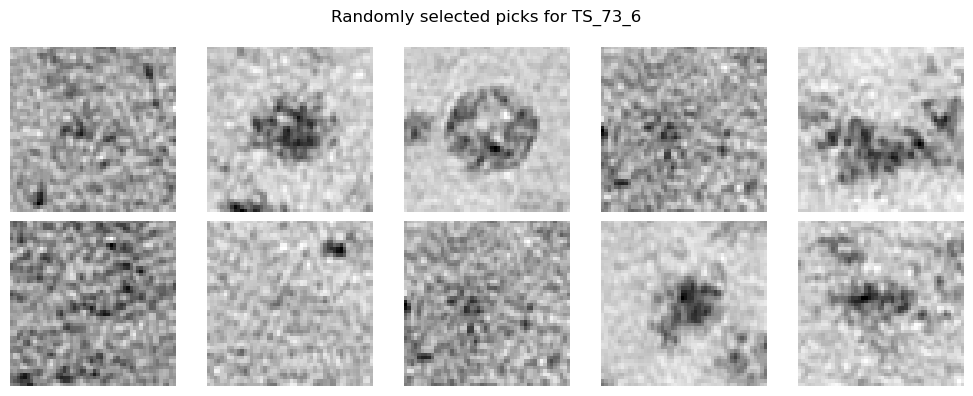

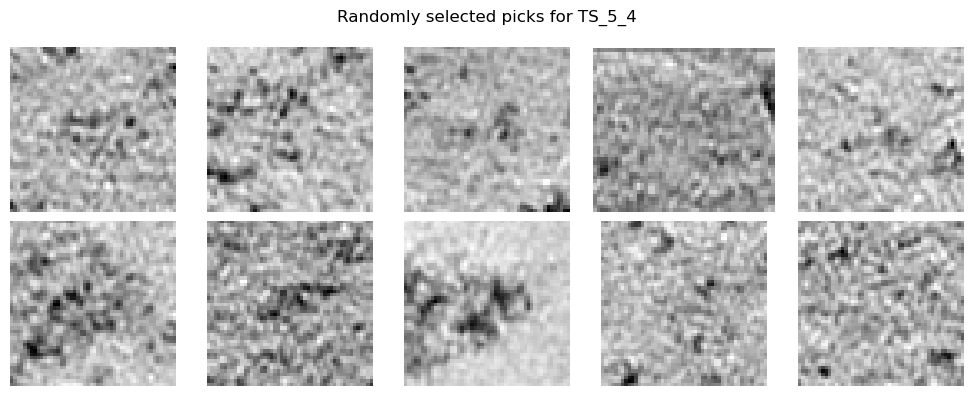

In [85]:
# Random selection of the reference particles


for tomo in predicted_positives:
    selected_picks = rng.choice(
        predicted_positives[tomo][["X", "Y", "Z"]].values, 10, replace=False
    )

    # the located coordinates are often subpixel, so we need to round them to the nearest integer
    selected_picks = np.floor(selected_picks).astype(int)

    tomo_array = copick_tools.get_copick_tomogram(
        copick_root, voxelSize=voxel_size, tomoAlgorithm="denoised", tomoID=tomo
    )
    tomo_array_xyz = np.transpose(tomo_array, (2, 1, 0))

    # Extract the reference projections and plot them

    reference_projections = [
        helper.get_particle_slab_projection(
            tomo_array_xyz=tomo_array_xyz, particle_coord_xyz=coords
        )
        for coords in selected_picks
    ]
    fig, axs = plt.subplots(
        2,
        5,
        figsize=(10, 4),
    )
    for i, ax in enumerate(axs.flat):
        ax.imshow(reference_projections[i], cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Randomly selected picks for {tomo}")
    plt.tight_layout()
    plt.show()

---


### <span style="color:#d65d0e"> Evaluating the picks </span>

The figures above should show that some picks that do not look like ribosomes. For annotated tomograms, we can retrieve the ground truth particles to quantitatively evaluate the picking.


In [86]:
# First getting the ground truth ribosome locations for the test tomograms
gt_coords = {}
for tomo in test_tomos:
    coords_xyz = copick_tools.custom_get_copick_protein_coords(copick_root, tomo, "ribosome")
    gt_coords[tomo] = pd.DataFrame(coords_xyz, columns=["X", "Y", "Z"])

In [87]:
classification_metrics = {}
for tomo in test_tomos:
    print(f"Calculating metrics for {tomo}")
    classification_metrics[tomo] = helper.calculate_metrics(
        gt_picks_df=gt_coords[tomo],
        tomotwin_picks_df=tomotwin_picks_dfs[tomo],
        class_prediction_threshold=class_prediction_threshold,
        connected_size_threshold=connected_size_threshold,
        gt_threshold_distance=protein_diameters[protein] / 2,
        fp_repeat_threshold_distance=protein_diameters[protein],
    )

Calculating metrics for TS_73_6
Calculating metrics for TS_5_4


In [88]:
for tomo in test_tomos:
    print(f"Metrics for {tomo}")
    print(
        "Number of true positives: ",
        len(classification_metrics[tomo]["true_positives"]),
    )
    print(
        "Number of false positives: ",
        len(classification_metrics[tomo]["false_positives"]),
    )
    print(
        "Number of false negatives: ",
        len(classification_metrics[tomo]["false_negatives"]),
    )
    print(f"Precision: {classification_metrics[tomo]['precision']: 3.2f}")
    print(f"Recall: {classification_metrics[tomo]['recall']: 3.2f}")
    print()

Metrics for TS_73_6
Number of true positives:  69
Number of false positives:  520
Number of false negatives:  4
Precision:  0.12
Recall:  0.95

Metrics for TS_5_4
Number of true positives:  36
Number of false positives:  553
Number of false negatives:  9
Precision:  0.06
Recall:  0.80



<a id='section4'></a>

## <span style="color:#d65d0e"> Observations </span>

Particle picking is hard!

Tomotwin is a powerful state-of-the-art approach for de novo, interactive, particle picking for cryo-EM tomograms. When we adopt it for ribosome picking in high-throughput non-interactive particle picking, we can identify some ribosomes, but we also miss some, and we generate a lot of false positives. In our experience, picking small particles is even more difficult.

We want to emphasize that this notebook is only an example of a particle picking workflow, and is not expected to be the gold standard for Tomotwin-based workflows, let alone for a broader variety of workflows. We hope that other approaches can greatly simplify and improve upon these workflows. For now, however, particle picking is hard!
